In [230]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [231]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Normalizer , scale
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [232]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [233]:
import os
print(os.getcwd())


/kaggle/working


In [234]:
# get titanic & test csv files as a DataFrame


train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


In [235]:
full.head(20)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [236]:
titanic.describe()


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


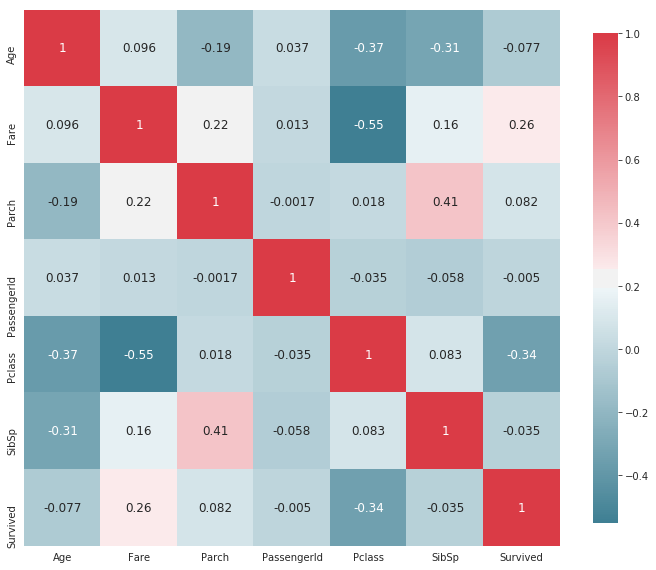

In [237]:
plot_correlation_map( titanic )


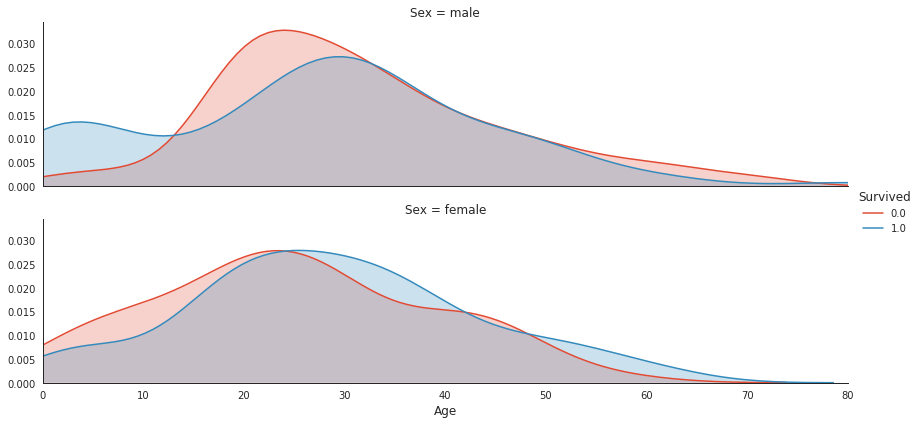

In [238]:
# Plot distributions of Age of passengers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

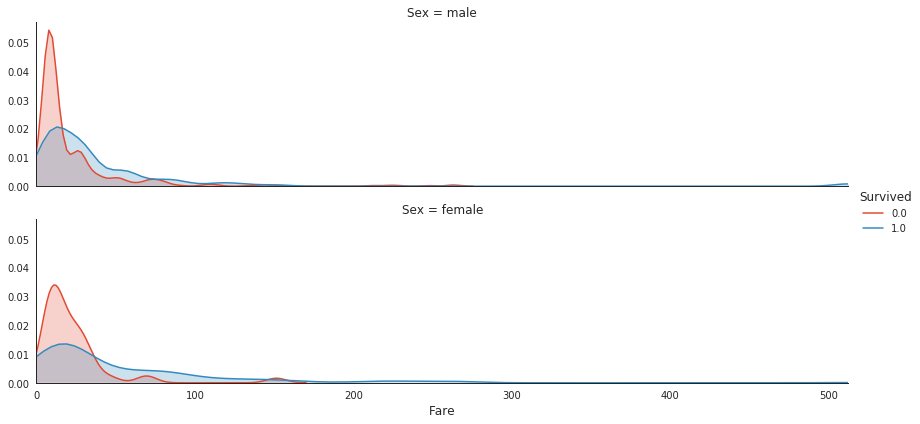

In [239]:
# Plot distributions of Fare of passangers who survived or did not survive
plot_distribution( titanic , var = 'Fare' , target = 'Survived' , row = 'Sex' )

#https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial

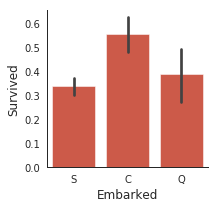

In [240]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

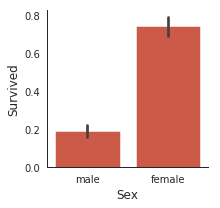

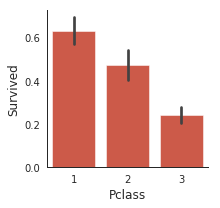

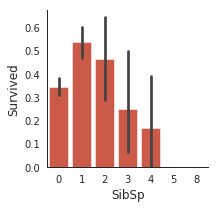

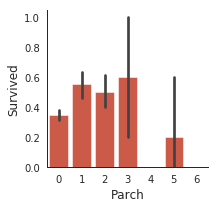

In [241]:
for i in ['Sex', 'Pclass', 'SibSp' , 'Parch'] :
    plot_categories( titanic , cat = i , target = 'Survived' )

In [242]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [243]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [244]:
# Create a new variable for every unique value of Pclass
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [245]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [246]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

In [247]:
# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [248]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [249]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [250]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [251]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket

full_X = pd.concat( [ imputed , title , pclass , sex ,family ] , axis=1 )
full_X.head()

,Age,Fare,Master,Miss,Mr,Mrs,Officer,Royalty,Pclass_1,Pclass_2,Pclass_3,Sex,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,7.2500,0,0,1,0,0,0,0,0,1,1,2,0,1,0
1,38.0,71.2833,0,0,0,1,0,0,1,0,0,0,2,0,1,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,1,0,1,1,0,0
3,35.0,53.1000,0,0,0,1,0,0,1,0,0,0,2,0,1,0
4,35.0,8.0500,0,0,1,0,0,0,0,0,1,1,1,1,0,0


In [252]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(1309, 16) (623, 16) (268, 16) (623,) (268,) (418, 16)


0.9903691813804173


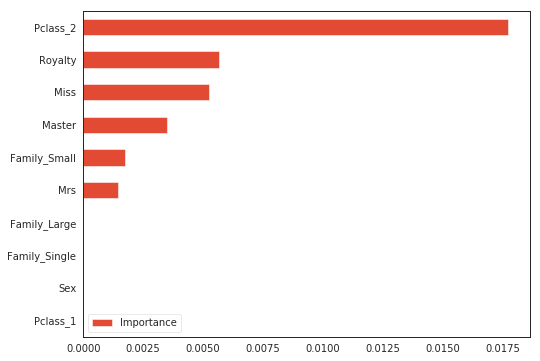

In [253]:
plot_variable_importance(train_X, train_y)

1. **Random Forests Model**

In [254]:
model = RandomForestClassifier(n_estimators=100)

In [255]:
model.fit( train_X , train_y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [256]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.9903691813804173 0.832089552238806


0.9903691813804173


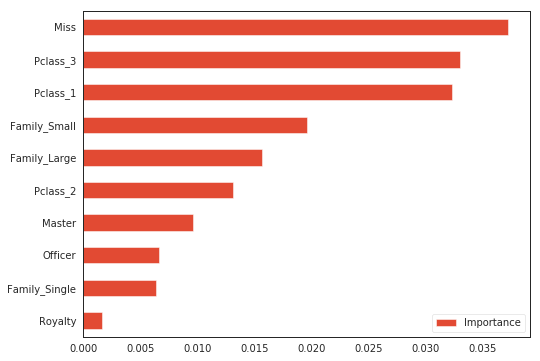

In [257]:
plot_model_var_imp(model, train_X, train_y)


0.9903691813804173 0.832089552238806
Optimal number of features : 13


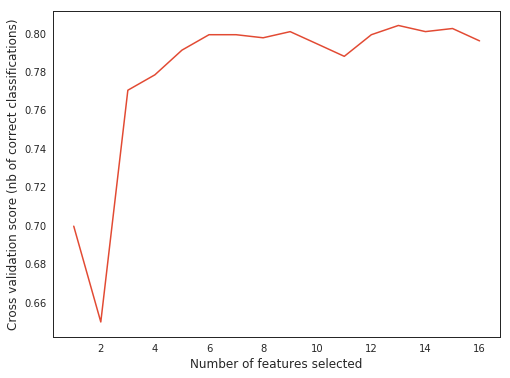

In [258]:
rfecv = RFECV( estimator = model , step=1 , cv=StratifiedKFold(2) , scoring='accuracy' )

rfecv.fit( train_X , train_y )

print (rfecv.score( train_X , train_y ) , rfecv.score( valid_X , valid_y ))
print( "Optimal number of features : %d" % rfecv.n_features_ )

#Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()


2. **Support Vector Machines**

In [259]:
model=SVC()
model.fit( train_X , train_y )

# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.6741573033707865 0.6865671641791045


3. **Logistic Regression**

In [260]:
model=LogisticRegression()
model.fit( train_X , train_y )

# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.9181380417335474 0.835820895522388


4. **K-nearest neighbors**

In [261]:
model=KNeighborsClassifier(n_neighbors = 3)
model.fit( train_X , train_y )

# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.8362760834670947 0.7313432835820896


5. **Gaussian Naive Bayes**

In [262]:
model=GaussianNB()
model.fit( train_X , train_y )

# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.8154093097913323 0.8470149253731343


6. **Gradient Boosting Classifier**

In [263]:
model=GradientBoostingClassifier()
model.fit( train_X , train_y )

# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.8186195826645265 0.8507462686567164


In [ ]:
test_Y = model.predict( test_X )
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred.csv' , index = False )